In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!pip install albumentations==0.4.6
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
# 이미지 시각화
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
import cv2
from PIL import Image
%matplotlib inline
import torch
import torchvision
from torchvision import transforms # 이미지 데이터 transform
from torch.utils.data import DataLoader # 이미지 데이터 로더
import os
import glob
import albumentations as A
from albumentations.pytorch import ToTensorV2

In [ ]:
os.chdir('/content/drive/MyDrive/colabpro')

In [ ]:
train_img = glob.glob('dataset/train/imgs/*.jpg')
train_mask= glob.glob('dataset/train/masks/*jpg')
test_img = glob.glob('dataset/test/imgs/*.jpg')
test_mask = glob.glob('dataset/test/masks/*.jpg')

In [ ]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

torch.manual_seed(777)
if device == 'cuda':
    torch.cuda.manual_seed_all(777)

In [ ]:
len(train_img) , len(train_mask) , len(test_img) , len(test_mask)

(68, 68, 16, 16)

In [ ]:
train_transform = A.Compose(
    [
        A.Resize(256, 256),
        A.ShiftScaleRotate(shift_limit=0.2, scale_limit=0.2, rotate_limit=30, p=0.5),
        A.RGBShift(r_shift_limit=25, g_shift_limit=25, b_shift_limit=25, p=0.5),
        A.RandomBrightnessContrast(brightness_limit=0.3, contrast_limit=0.3, p=0.5),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        A.VerticalFlip(p = 0.5),
        A.Rotate(limit = 40) ,
        ToTensorV2(),
    ]
)

test_transform = A.Compose(
        [
        A.Resize(256, 256),
        A.Normalize(mean=(0.485, 0.456, 0.406), std=(0.229, 0.224, 0.225)),
        ToTensorV2(),
    ]
)

In [ ]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self , data_dir , transform = None):
        self.data_dir = data_dir
        self.transform = transform
        img_paths = glob.glob(os.path.join(self.data_dir , 'imgs/*.jpg'))
        mask_paths = glob.glob(os.path.join(self.data_dir , 'masks/*.jpg'))
        self.img_paths = sorted(img_paths)
        self.mask_paths = sorted(mask_paths)
        
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = self.img_paths[idx]
        mask_path = self.mask_paths[idx]
        img = Image.open(img_path)
        mask = Image.open(mask_path)
        image = np.array(img)
        mask = np.array(mask)
        
        if self.transform is not None:
            transformed = self.transform(image = image , mask = mask)
            image = transformed['image']
            mask = transformed['mask']
            mask = mask.unsqueeze(dim = 0)
            mask = torch.as_tensor(mask ,dtype = torch.float32, device='cpu')
        return image , mask

In [ ]:
train_dataset = CustomDataset('dataset/train' , transform = train_transform )
test_dataset = CustomDataset('dataset/test' ,transform = test_transform )

In [ ]:
def imshow(img, mean, std):
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    plt.imshow(img)
    plt.show()

In [ ]:
mean=[0.485, 0.456, 0.406], 
std=[0.229, 0.224, 0.225]

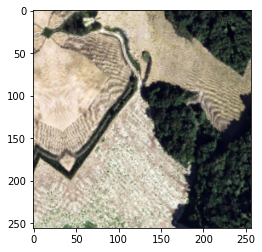

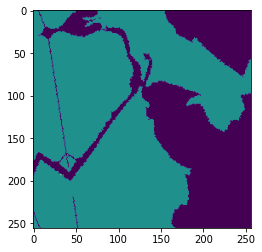

In [ ]:
## image 시각화
pre_img , pre_mask = train_dataset[1]
plt.figure()
imshow(pre_img , mean , std )
plt.figure()
plt.imshow(pre_mask.squeeze() )

In [ ]:
import torch
import torch.nn as nn
import torchsummary
import torchvision
import torch.nn.functional as F

In [ ]:
class UNet(nn.Module):
    def __init__(self):
        super(UNet , self).__init__()
        def CBR2d(in_channels , out_channels , kernel_size = 3 , stride = 1 , padding = 1 , bias = True):
            layers = []
            layers += [nn.Conv2d(in_channels = in_channels ,out_channels = out_channels , 
                                kernel_size = kernel_size , stride = stride , padding = padding , 
                                bias = bias)]
            layers += [nn.BatchNorm2d(num_features = out_channels)]
            layers += [nn.ReLU()]

            cbr = nn.Sequential(*layers)
            return cbr

        def make_layer(in_channels , out_channels , kernel_size = 3 , stride = 1 , padding = 1 , bias = True):
            layer_1  = CBR2d(in_channels , out_channels)
            layer_2 = CBR2d(out_channels , out_channels)
            return nn.Sequential(layer_1 , layer_2)
        def make_layer_dec(in_channels , out_channels , kernel_size = 3 , stride = 1 , padding = 1 , bias = True):
            layer_1  = CBR2d(in_channels , out_channels // 2)
            layer_2 = CBR2d(out_channels //2, out_channels)
            return nn.Sequential(layer_1 , layer_2)

        self.enc1 = make_layer(3 , 64)
        self.enc2 = make_layer(64 , 128)
        self.enc3 = make_layer(128, 256)
        self.enc4 = make_layer(256 , 512)
        self.enc5 = CBR2d(in_channels= 512 , out_channels= 1024)

        self.dec5 = CBR2d(in_channels= 1024 , out_channels= 512)

        self.unpool4 = nn.ConvTranspose2d(in_channels=512, out_channels=512,
                                        kernel_size=2, stride=2, padding=0, bias=True)
        self.dec4 = make_layer_dec(2* 512 , 256)
        self.unpool3 = nn.ConvTranspose2d(in_channels=256, out_channels=256,
                                        kernel_size=2, stride=2, padding=0, bias=True)
        self.dec3 = make_layer_dec(2* 256 , 128)
        self.unpool2 = nn.ConvTranspose2d(in_channels=128, out_channels=128,
                                        kernel_size=2, stride=2, padding=0, bias=True)
        self.dec2 = make_layer_dec(2* 128 , 64)
        self.unpool1 = nn.ConvTranspose2d(in_channels=64, out_channels=64,
                                        kernel_size=2, stride=2, padding=0, bias=True)
        self.dec1 = make_layer(2* 64 , 64)
        self.fc = nn.Conv2d(in_channels=64, out_channels=1, kernel_size=1, stride=1, padding=0, bias=True)

    def forward(self , x):
        #######################
        #### Contraction  #####
        #######################
        #1번 box input 3 out 64
        out = self.enc1(x)
        step1 = out
        out = F.max_pool2d(out, 2 , 2 )
        #2번 input 64 out 128
        out = self.enc2(out)
        step2 = out
        out = F.max_pool2d(out, 2 , 2 )
        #3번 input 128 out 256
        out = self.enc3(out)
        step3 = out
        out = F.max_pool2d(out, 2 , 2 )
        #4번 box  input 256 out 512
        out = self.enc4(out)
        step4 = out
        out = F.max_pool2d(out, 2 , 2 )
        #5번 box input 512 out 1024
        out = self.enc5(out)
        #5번 box    input 1024 out 512
        out = self.dec5(out)

        #######################
        #### Expansion  #####
        #######################
        out = self.unpool4(out)
        # box 512 *2 out 512
        out = torch.cat((out , step4) , dim = 1)
        out = self.dec4(out)
        out = self.unpool3(out)
        #3번 box cat input 256 * 2 out 256
        out = torch.cat((out , step3) , dim = 1)
        out = self.dec3(out)
        out = self.unpool2(out)
        #2번 box cat input 128 * 128 out 128
        out = torch.cat((out , step2) , dim = 1)
        out = self.dec2(out)
        out = self.unpool1(out)
        #1번 box cat input 64 *2 out 64
        out = torch.cat((out , step1) , dim = 1)
        out = self.dec1(out)
        #4번 prediction
        out = self.fc(out)

        return out

In [ ]:
model = UNet()
model.to(device)

UNet(
  (enc1): Sequential(
    (0): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (enc2): Sequential(
    (0): Sequential(
      (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (1): Sequential(
      (0): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
  )
  (enc3): Sequential(
    (0): Sequential(
      (0): Conv2d(128, 256, kernel_size=(3,

In [ ]:
torchsummary.summary(model , (3, 256, 256) ,    batch_size = 8)


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [8, 64, 256, 256]           1,792
       BatchNorm2d-2          [8, 64, 256, 256]             128
              ReLU-3          [8, 64, 256, 256]               0
            Conv2d-4          [8, 64, 256, 256]          36,928
       BatchNorm2d-5          [8, 64, 256, 256]             128
              ReLU-6          [8, 64, 256, 256]               0
            Conv2d-7         [8, 128, 128, 128]          73,856
       BatchNorm2d-8         [8, 128, 128, 128]             256
              ReLU-9         [8, 128, 128, 128]               0
           Conv2d-10         [8, 128, 128, 128]         147,584
      BatchNorm2d-11         [8, 128, 128, 128]             256
             ReLU-12         [8, 128, 128, 128]               0
           Conv2d-13           [8, 256, 64, 64]         295,168
      BatchNorm2d-14           [8, 256,

In [ ]:
lr = 0.001
batch_size = 8
epochs = 500
criterion = nn.BCEWithLogitsLoss().to(device)
optimizer = torch.optim.Adam(model.parameters() , lr = lr)

In [ ]:
fn_tonumpy = lambda x : x.to('cpu').detach().numpy().transpose(0 , 2 , 3 , 1)
fn_denorm = lambda x , mean , std: (x * std) + mean
fn_class = lambda x : 1.0 * (x > 0.5)

In [ ]:
### data paraell 이랑 num_worker고찰해보자
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16,
                                          shuffle=True, num_workers=4)

test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=16,
                                         shuffle=False, num_workers=4)

In [ ]:
for epoch in range(epochs):
    model.train()
    loss_arr = []
    
    for batch , data in enumerate(train_loader , 1):
        image , label = data
        image = image.to(device)
        label = label.to(device)
        
        output = model(image)
        optimizer.zero_grad()
        loss = criterion(output , label)
        loss.backward()
        optimizer.step()
        loss_arr += [loss.item()]
    
    print(f'Train EPOCH : {epoch} \n LOSS : {sum(loss_arr)}')

    
    with torch.no_grad():
        model.eval()
        loss_arr = []
        
        for batch , data in enumerate(test_loader , 1):
            image , label = data
            image = image.to(device)
            label = label.to(device)
            output = model(image)           
            
            loss = criterion(output , label)
            
            loss_arr += [loss.item()]
        print(f'Test EPOCH : {epoch} \n LOSS : {sum(loss_arr)}')
        print('-' * 50)

In [ ]:
output_list = []
label_list = [ ]
image_list = []
with torch.no_grad():
    model.eval()
    loss_arr = []
    
    for batch , data in enumerate(test_loader , 1):
        image , label = data
        image = image.to(device)
        label = label.to(device)
        output = model(image)           
        output_list.append(output)
        image_list.append(image)
        label_list.append(label)
        loss = criterion(output , label)
        
        loss_arr += [loss.item()]
    print(f'Test EPOCH : {epoch} \n LOSS : {sum(loss_arr)}')
    print('-' * 50)

Test EPOCH : 289 
 LOSS : 0.22856062650680542
--------------------------------------------------


In [ ]:
len(output_list)

1

In [ ]:
output_list[0].shape , label_list[0].shape ,image_list[0].shape

(torch.Size([16, 1, 256, 256]),
 torch.Size([16, 1, 256, 256]),
 torch.Size([16, 3, 256, 256]))

In [ ]:
def imshow(img, mean, std):
    img = img.to('cpu')
    npimg = img.numpy()
    img = np.transpose( npimg, (1, 2, 0) )
    img = img * std + mean # renormalize
    img = img.clip(0, 1)
    ax[0].imshow(img)

In [ ]:
import matplotlib
matplotlib.rcParams.update({'font.size': 22})

In [ ]:
for i in range(16):
    fig  , ax = plt.subplots(1,3, figsize = (16,5))
    imshow(image_list[0][i] , mean , std)
    ax[1].imshow(fn_class(label_list[0][i]).to('cpu').squeeze())
    ax[2].imshow(fn_class(output_list[0][i]).to('cpu').squeeze())
    ax[0].set_title('Image')
    ax[1].set_title('target')
    ax[2].set_title('pred')
    plt.show()